# Brain Tumour Detection

### Importing Libraries

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image, ImageEnhance

#keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from sklearn.utils import shuffle

### Loading Datasets

In [ ]:
train_dir = '/content/drive/MyDrive/MRI Images Main/Training/'
test_dir = '/content/drive/MyDrive/MRI Images Main/Testing/'

#load & shuffle train data
train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for img in os.listdir(os.path.join(train_dir, label)):
        train_paths.append(os.path.join(train_dir, label, img))
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels, random_state=42)

#load & shuffle test data
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for img in os.listdir(os.path.join(test_dir, label)):
        test_paths.append(os.path.join(test_dir, label, img))
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels, random_state=42)

### Data Visualization

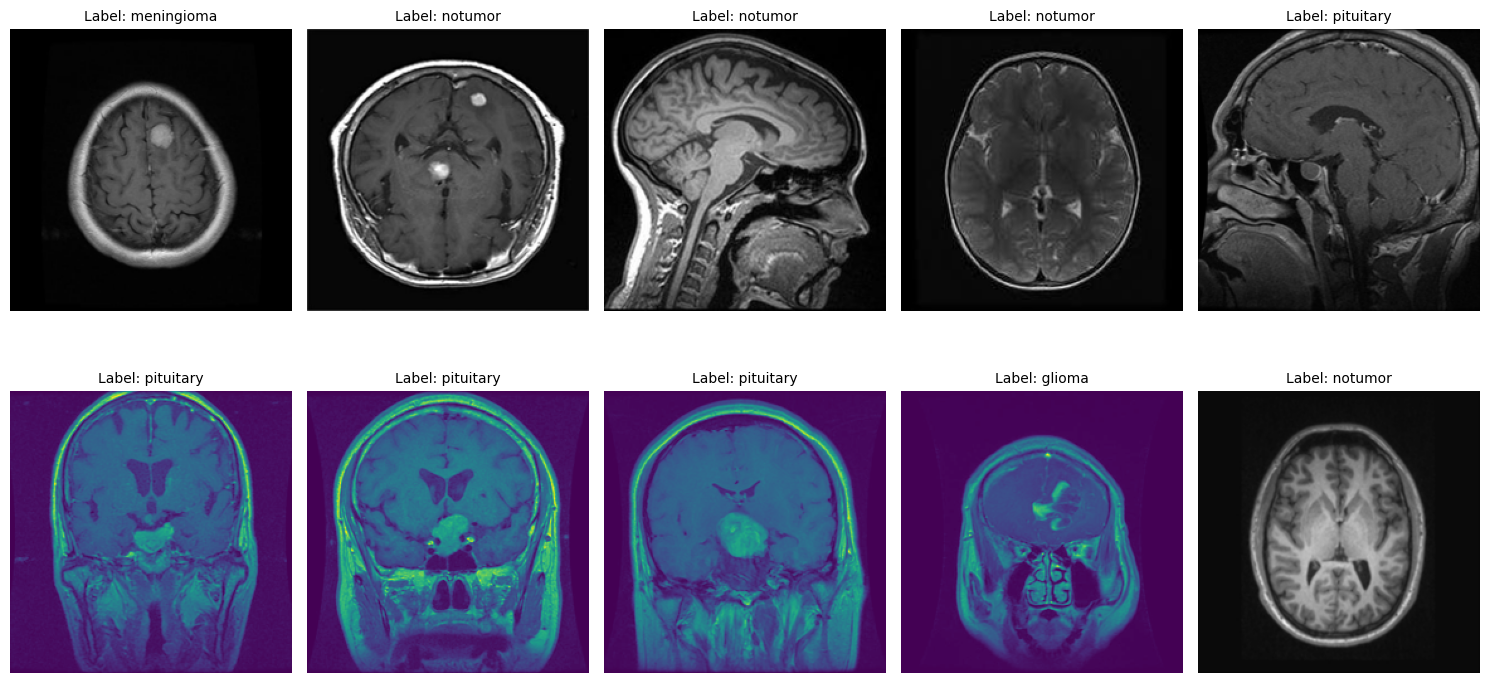

In [ ]:
# Select random indices for 10 images
random_indices = random.sample(range(len(train_paths)), 10)

# Create a figure to display images in 2 rows
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
axes = axes.ravel()

for i, idx in enumerate(random_indices):
    img_path = train_paths[idx]
    img = Image.open(img_path)
    img = img.resize((224, 224))

    # Display image
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f"Label: {train_labels[idx]}", fontsize=10)

plt.tight_layout()
plt.show()

### Image Preprocessing

In [ ]:
# Image Augmentation function
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))
    image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
    return image

# Load images and apply augmentation
def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

# Encoding labels (label names to integers)
def encode_label(labels):
    unique_labels = os.listdir(train_dir)
    encoded = [unique_labels.index(label) for label in labels]
    return np.array(encoded)

# Data generator for batching
def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[i:i + batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

## MODEL
### USING VGG16 FOR TRANSFER LEARNING

The model is based on **VGG16**, a pre-trained convolutional neural network (CNN) commonly used for image classification tasks.

- **Load the VGG16 model**  
  - `input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)`, `include_top=False`, and `weights='imagenet'` are used.  
  - The input shape matches the dataset images (128x128 pixels).
  - `include_top=False` excludes VGG16’s original classification layers.
  - `weights='imagenet'` loads pre-trained weights from the ImageNet dataset.

- **Freeze base model layers**  
  - All layers are set to non-trainable using a `for layer in base_model.layers` loop.

- **Fine-tune last layers**  
  - The last three layers are set to trainable:  
    - `base_model.layers[-2].trainable = True`
    - `base_model.layers[-3].trainable = True`
    - `base_model.layers[-4].trainable = True`

- **Build the Sequential model**  
  - Add the VGG16 base model with `model.add(base_model)`.

- **Flatten output**  
  - Add a Flatten layer: `model.add(Flatten())`.

- **Add Dropout layers**  
  - First Dropout layer with a 30% rate: `model.add(Dropout(0.3))`.
  - Second Dropout layer with a 20% rate: `model.add(Dropout(0.2))`.

- **Add Dense layers**  
  - Dense layer with 128 neurons and ReLU activation: `model.add(Dense(128, activation='relu'))`.

- **Output layer**  
  - Dense layer with the number of neurons equal to `len(unique_labels)` and a `softmax` activation:  
    `model.add(Dense(len(unique_labels), activation='softmax'))`.

---

### Transfer Learning

In [ ]:
IMAGE_SIZE = 128
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# Freeze all layers of the VGG16 base model
for layer in base_model.layers:
    layer.trainable = False

# Set the last few layers of the VGG16 base model to be trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

#Build final model
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))  # Input layer
model.add(base_model)  # Add VGG16 base model
model.add(Flatten())  # Flatten the output of the base model
model.add(Dropout(0.3))  # Dropout layer for regularization
model.add(Dense(128, activation='relu'))  # Dense layer with ReLU activation
model.add(Dropout(0.2))  # Dropout layer for regularization
model.add(Dense(len(os.listdir(train_dir)), activation='softmax'))  # Output layer with softmax activation

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

# Parameters
batch_size = 20
steps = int(len(train_paths) / batch_size)
epochs = 5

# Train the model
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/5
286/286 ━━━━━━━━━━━━━━━━━━━━ 2816s 10s/step - loss: 0.6876 - sparse_categorical_accuracy: 0.7277
Epoch 2/5
155/286 ━━━━━━━━━━━━━━━━━━━━ 10:47 5s/step - loss: 0.2538 - sparse_categorical_accuracy: 0.8984

### Accuracy and Loss Comparision

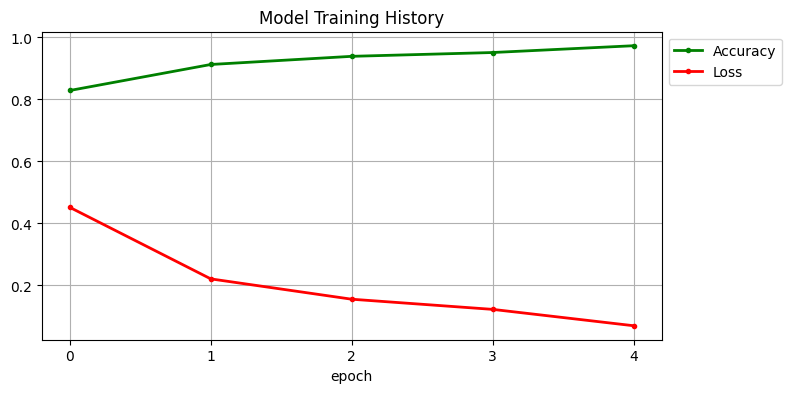

In [ ]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

### Model Classification

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model
import numpy as np

# 1. Prediction on test data
test_images = open_images(test_paths)  # Load and augment test images
test_labels_encoded = encode_label(test_labels)  # Encode the test labels

# Predict using the trained model
test_predictions = model.predict(test_images)

# 2. Classification Report
print("Classification Report:")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))

41/41 ━━━━━━━━━━━━━━━━━━━━ 231s 6s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       300
           1       0.94      0.86      0.90       306
           2       0.96      1.00      0.98       405
           3       0.93      0.99      0.96       300

    accuracy                           0.95      1311
   macro avg       0.95      0.94      0.94      1311
weighted avg       0.95      0.95      0.95      1311



### Confusion Matrix

Confusion Matrix:
[[278  14   7   1]
 [ 15 264   7  20]
 [  0   0 405   0]
 [  1   2   1 296]]


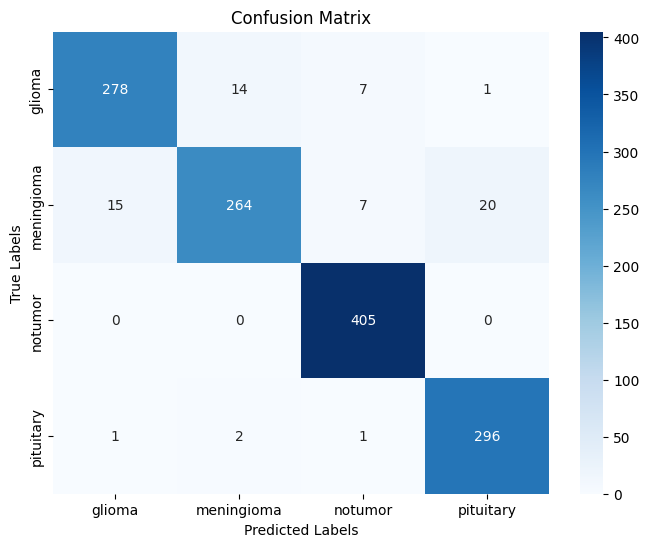

In [ ]:
# 3. Confusion Matrix
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
print("Confusion Matrix:")
print(conf_matrix)

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [ ]:
# Save the entire model
model.save('model.h5')

In [ ]:
#load model
model = tf.keras.models.load_model('model.h5')

### Detection Testing

In [ ]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Class labels
class_labels = ['pituitary', 'glioma', 'notumor', 'meningioma']

def detect_and_display(img_path, model, image_size=128):
    """
    Function to detect tumor and display results.
    If no tumor is detected, it displays "No Tumor".
    Otherwise, it shows the predicted tumor class and confidence.
    """
    try:
        # Load and preprocess the image
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make a prediction
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence_score = np.max(predictions, axis=1)[0]

        # Determine the class
        if class_labels[predicted_class_index] == 'notumor':
            result = "No Tumor"
        else:
            result = f"Tumor: {class_labels[predicted_class_index]}"

        # Display the image with the prediction
        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()

    except Exception as e:
        print("Error processing the image:", str(e))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


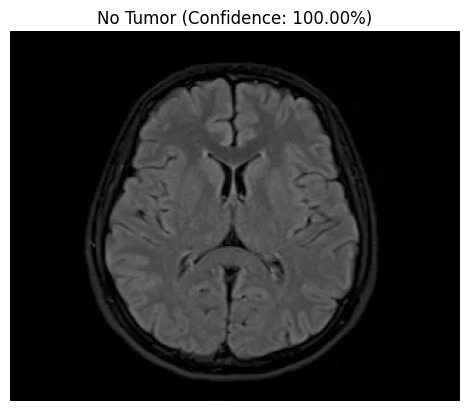

In [ ]:
image_path = '/content/drive/MyDrive/MRI Images Main/Testing/notumor/Te-noTr_0002.jpg'
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


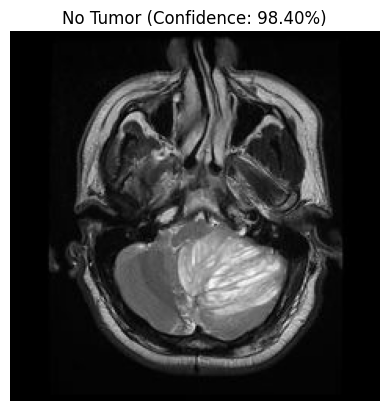

In [ ]:
img_path = '/content/drive/MyDrive/MRI Images Main/Testing/notumor/Te-no_0097.jpg'
detect_and_display(img_path, model)